<a href="https://colab.research.google.com/github/TAUforPython/stohasticsignal/blob/main/%D1%81%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn

In [ ]:
!pip install MFDFA

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

# создаем данные для обработки

либо загрузить, либо сгенерировать сигнал. Запустить что-то одно.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# путь к файлу на гугл-диске
edf_path = '/content/drive/MyDrive/edf_process/EDF_example_FS_healthy.edf'

# загрузка файла (данные в структуре переданы в переменную)
data_from_raw_edf = mne.io.read_raw_edf(edf_path, preload=True)

Mounted at /content/drive
Extracting EDF parameters from /content/drive/MyDrive/edf_process/EDF_example_FS_healthy.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 28799  =      0.000 ...   224.992 secs...


Using matplotlib as 2D backend.
['EEG Fp1-G2', 'EEG Fpz-G2', 'EEG Fp2-G2', 'EEG F7-G2', 'EEG F3-G2', 'EEG Fz-G2', 'EEG F4-G2', 'EEG F8-G2', 'EEG T3-G2', 'EEG C3-G2', 'EEG Cz-G2', 'EEG C4-G2', 'EEG T4-G2', 'EEG T5-G2', 'EEG P3-G2', 'EEG Pz-G2', 'EEG P4-G2', 'EEG T6-G2', 'EEG O1-G2', 'EEG O2-G2', 'EEG F9-G2', 'EEG T9-G2', 'EEG ECG-G2', 'EEG P9-G2', 'EEG F10-G2', 'EEG T10-G2', 'EEG P10-G2', 'Value MKR+-MKR-']


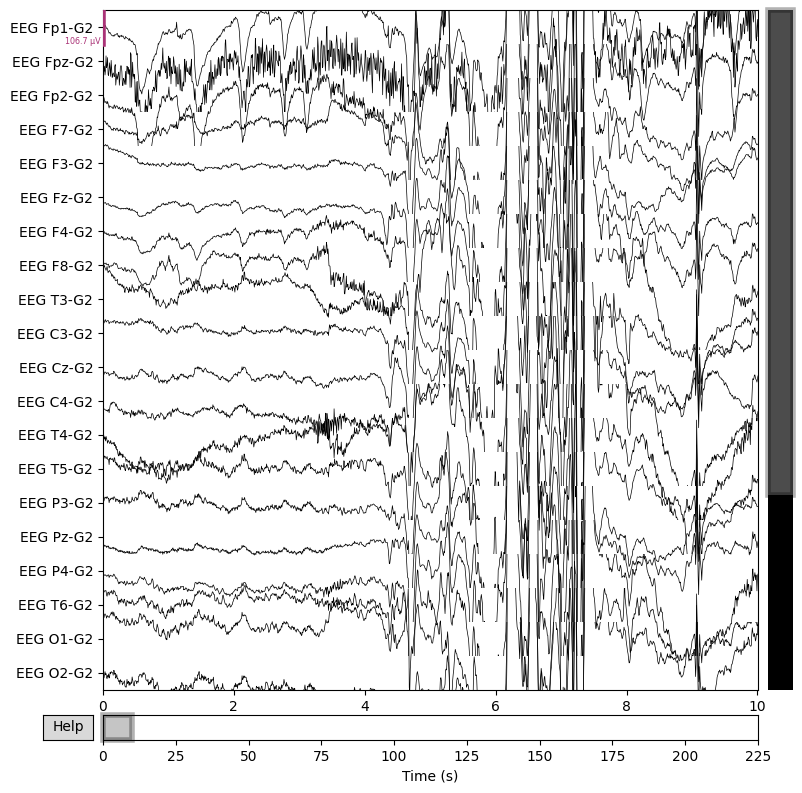

In [ ]:
# EDF - файл содержит многоканальную запись ЭЭГ
# ECG - файл содержит запись электрокардиограммы
data_from_raw_edf.plot(scalings = 'auto', show = False)
# список каналов из файла EDF
print(data_from_raw_edf.ch_names)

In [ ]:
eeg_data, eeg_times = data_from_raw_edf.get_data(return_times=True)
print('число отчетов во временном ряду:',len(eeg_times))
# устанавливаем диапазон для обработки данных
t_index_begin = 1500
t_index_end = 20000
t = eeg_times[t_index_begin:t_index_end]
# значение времени = конец сигнала
T = t[-1]
# число элементов во временном ряду
N = len(t)
# выгружаем в выходную переменную, например, первый (в Питоне он нулевой индекс имеет) канал
y = eeg_data[5, t_index_begin:t_index_end]

число отчетов во временном ряду: 28800


In [28]:
# функция генерации сигнала стохастического
def dataset_stohastic(mu, noise_sigma, data_size, random_state):
    t = np.arange(0, data_size, 1.)
    random.seed(random_state)
    noise = np.empty((data_size, 1))
    y = np.empty((data_size))

    for i in range(data_size):
        noise[i] = random.gauss(mu, noise_sigma)
        y[i] = 0*np.sin(t[i]) + noise[i]

    return t, y

data_size = 150 # размер генерируемого набора данных
noise_sigma = 0.5 # СКО шума в данных
mu = 10 # математическое ожидание
t, y = dataset_stohastic(mu, noise_sigma, data_size, 1)

In [ ]:
# фрактельный стохастический сигнал

from MFDFA import fgn
# integration time and time sampling
t_final = 200
delta_t = 0.01

# Some drift theta and diffusion sigma parameters
theta = 0.3
sigma = 0.1

# The time array of the trajectory
time = np.arange(0, t_final, delta_t)

# The fractional Gaussian noise
H = 0.7
dB = (t_final ** H) * fgn(N = time.size, H = H)

# Initialise the array y
y = np.zeros([time.size])

# Integrate the process
for i in range(1, time.size):
    y[i] = y[i-1] - theta * y[i-1] * delta_t + sigma * dB[i]

# Базовые методы исследования стохастического сигнала

Text(0, 0.5, 'y (экспериментальные измерения с шумом)')

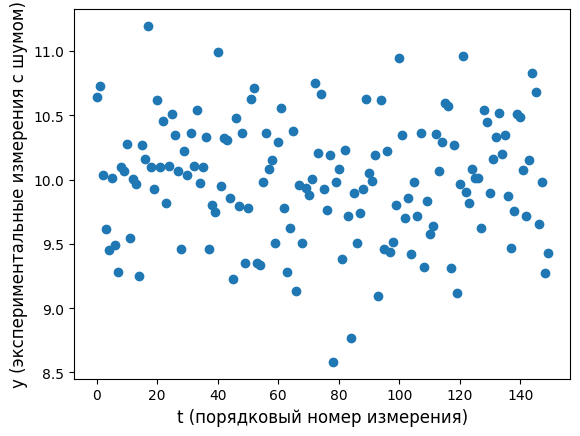

In [29]:
# изображение исследуемого графика
plt.plot(t, y, 'o')
plt.xlabel('t (порядковый номер измерения)', fontsize=12)
plt.ylabel('y (экспериментальные измерения с шумом)', fontsize=12)

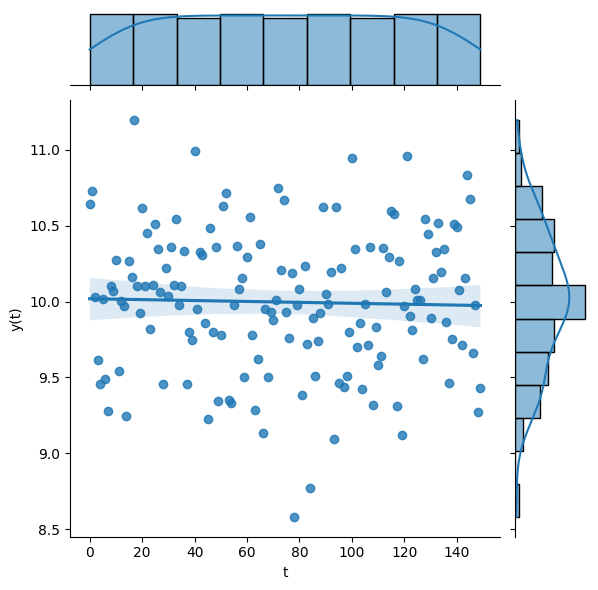

In [ ]:
# создаем датафрейм для красивого изображения данных
# сигнал случайный, формируем одну выборку

d = {'y(t)': y, 't': t}
df = pd.DataFrame(d)
seaborn.jointplot(data=df, x = "t", y = "y(t)",kind='reg')

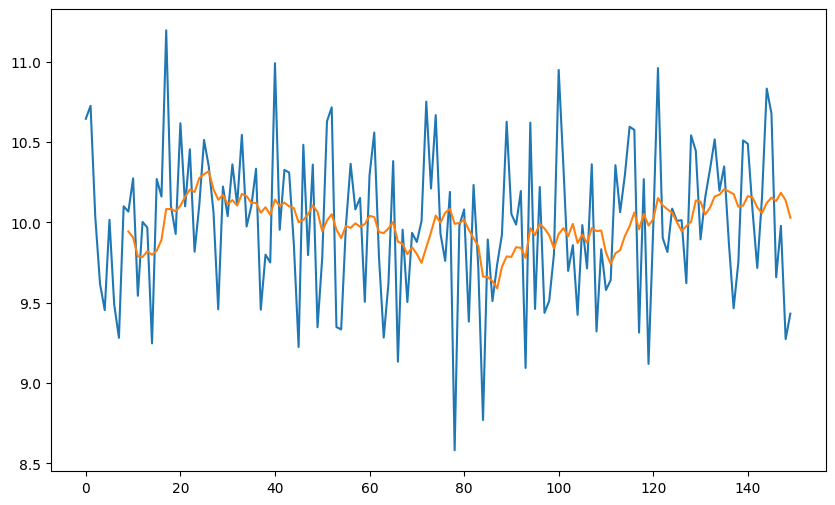

In [ ]:
# расчет скользящего среднего
df['y(t)'].plot(figsize=(10,6))
df['y(t)'].rolling(window = 10).mean().plot()
y_mean = df['y(t)'].rolling(window = 10).mean()

          t          y
0       0.0  10.470858
1       1.0   9.301711
2       2.0   9.660143
3       3.0  10.185252
4       4.0   9.491826
...     ...        ...
4495  145.0  10.236706
4496  146.0  10.059290
4497  147.0   9.969822
4498  148.0   9.368979
4499  149.0  10.673419

[4500 rows x 2 columns]


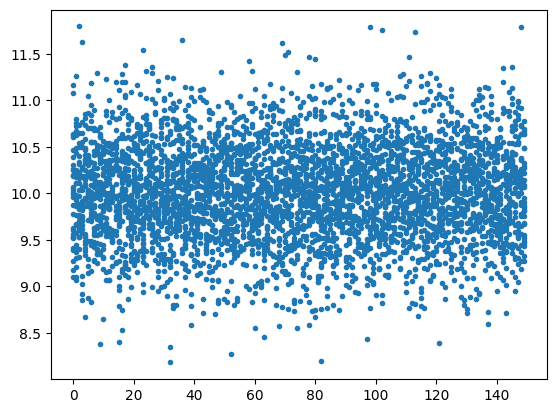

In [ ]:
x_cortege = []
y_cortege = []
for i in range(30):
     x_t, y_t = dataset_stohastic(mu, noise_sigma, data_size, i)
     x_cortege = np.append(x_cortege, x_t)
     y_cortege = np.append(y_cortege, y_t)
plt.plot(x_cortege,y_cortege,'.')
dataframe_cortege = {
    "t": x_cortege,
    "y": y_cortege
}
df = pd.DataFrame(dataframe_cortege)

print(df)

<Axes: xlabel='t', ylabel='y'>

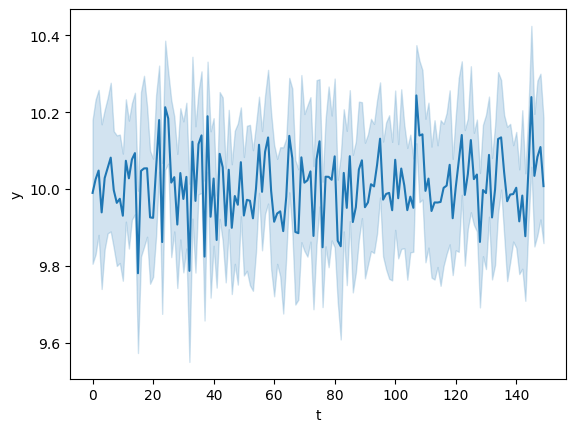

In [ ]:
seaborn.lineplot(x = "t", y= "y", data = df, markers = True)

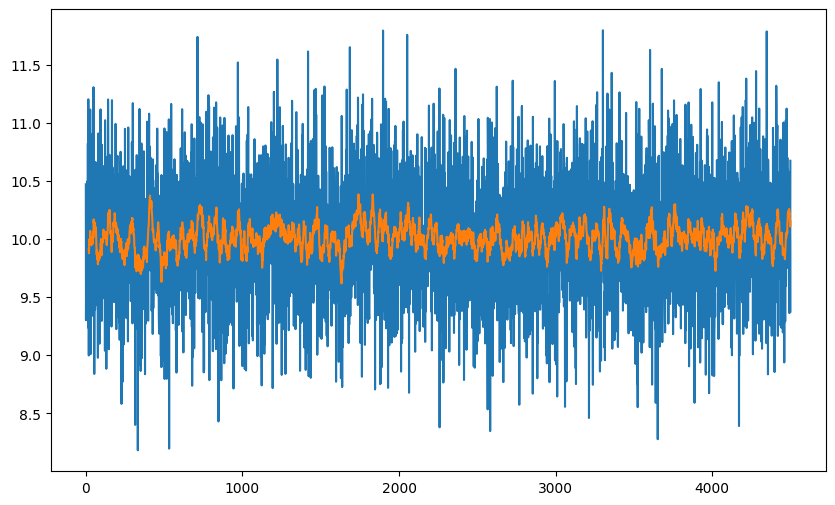

In [ ]:
df['y'].plot(figsize=(10,6))
df['y'].rolling(window = 20).mean().plot()
y_mean = df['y'].rolling(window = 20).mean()

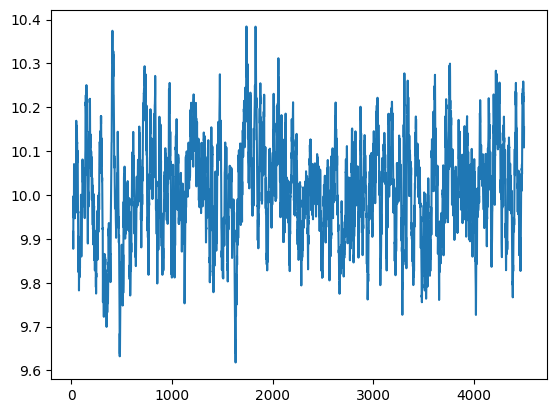

In [ ]:
plt.plot(y_mean)

# экспонента Хёрста и метод DFA

In [3]:
pip install hurst

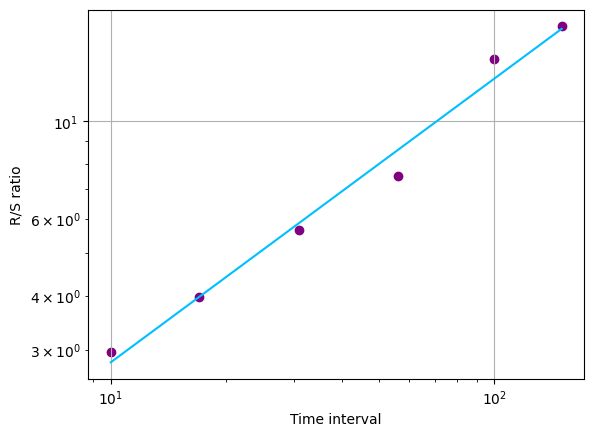

H=0.6483, c=0.6325


In [30]:
from hurst import compute_Hc
# Evaluate Hurst equation
H, c, data = compute_Hc(y, kind='change', simplified=False)

# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

In [4]:
pip install scipy

In [ ]:
from scipy import stats
def dfa(signal, scales):
    flucts = []
    for s in scales:
        windows = np.array([signal[i:i + s] for i in range(0, len(signal), s) if i + s <= len(signal)])
        detrended_windows = np.array([window - stats.linregress(np.arange(s), window)[0] * np.arange(s) - stats.linregress(np.arange(s), window)[1] for window in windows])
        F = np.sqrt(np.mean(detrended_windows**2, axis=1))
        flucts.append(np.mean(F))
    return np.array(flucts)

def sliding_window_std(signal, window_size):
    std_vals = np.array([np.std(signal[i:i+window_size]) for i in range(len(signal) - window_size + 1)])
    return std_vals

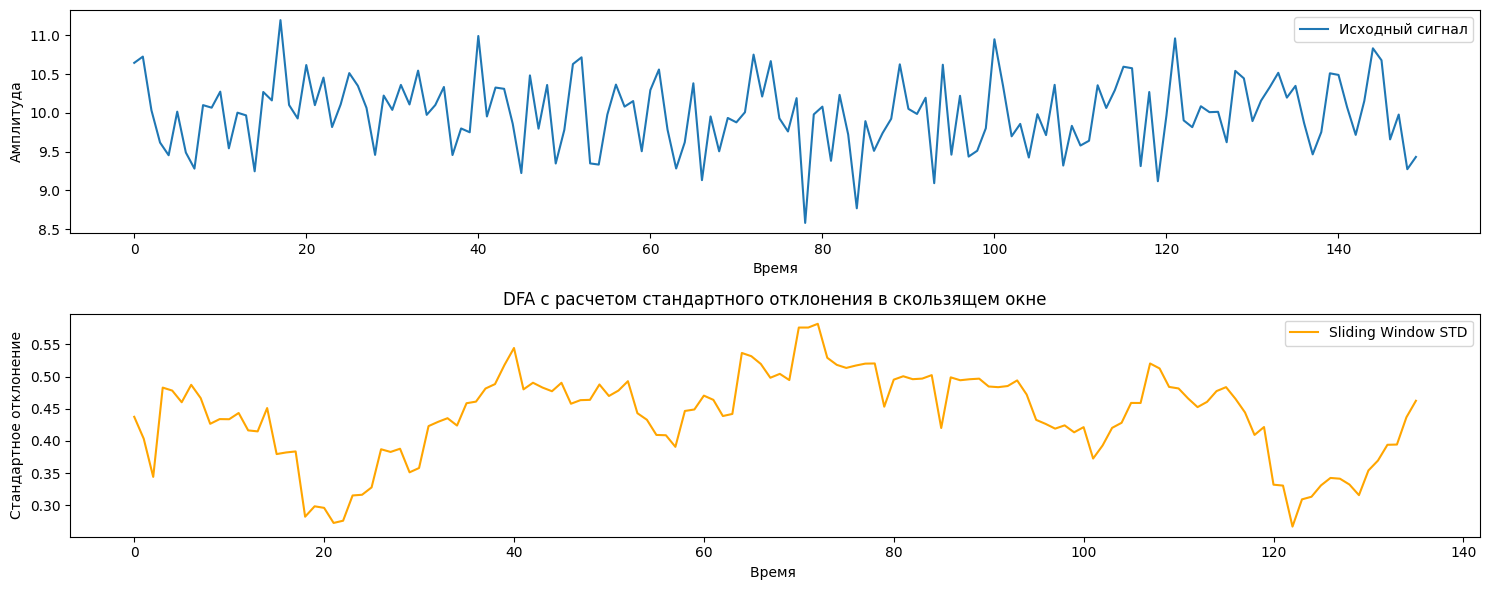

In [ ]:
window_size = int(len(y)/10)

std_vals = sliding_window_std(y, window_size)

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Исходный сигнал')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:-(window_size-1)], std_vals, label='Sliding Window STD', color='orange')
plt.title('DFA с расчетом стандартного отклонения в скользящем окне')
plt.xlabel('Время ')
plt.ylabel('Стандартное отклонение')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
scales = np.arange(int(t[1]), int(t[-1]), 1)
flucts = dfa(y, scales)
log_scales = np.log10(scales)
log_flucts = np.log10(flucts)
hurst_exponent, _, _, _, _ = stats.linregress(log_scales, log_flucts)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


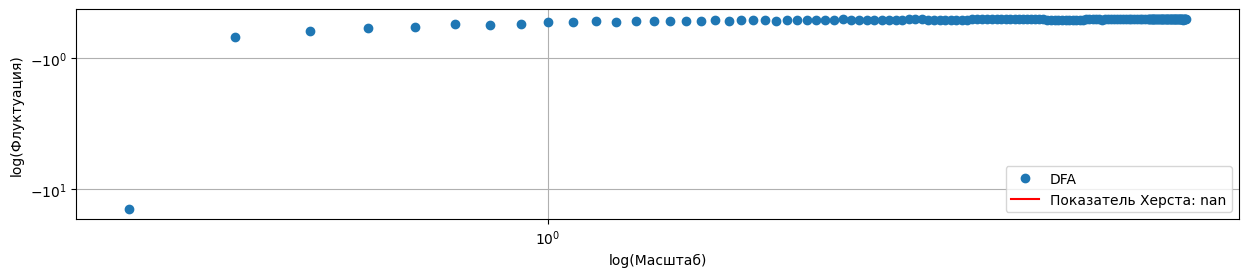

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(log_scales, log_flucts, 'o', label='DFA')
plt.plot(log_scales, hurst_exponent*log_scales + _, 'r', label=f'Показатель Херста: {hurst_exponent:.2f}')
plt.xscale("symlog")
plt.yscale("symlog")
plt.xlabel('log(Масштаб)')
plt.ylabel('log(Флуктуация)')
plt.grid()
plt.legend()

https://mfdfa.readthedocs.io

https://github.com/LRydin/MFDFA/blob/master/MFDFA/MFDFA.py


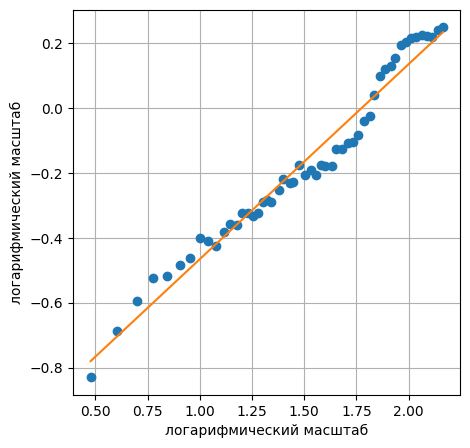

Estimated H = -0.399


In [96]:
# Imports
from MFDFA import MFDFA

# Select a band of lags, which usually ranges from
# very small segments of data, to very long ones, as
lag = np.unique(np.logspace(0.5, 3, 100, dtype=int))

# Notice these must be ints, since these will segment
# the data into chucks of lag size

# Select the power q
q = 2

# The order of the polynomial fitting
order = 1

# Obtain the (MF)DFA as
lag, dfa = MFDFA(y, lag = lag, q = q, order = order)

# To uncover the Hurst index, lets get some log-log plots

# And now we need to fit the line to find the slope
# in a double logaritmic scales, i.e., you need to
# fit the logs of the results

del_nan = np.argwhere(np.isnan(dfa))
dfa = np.delete(dfa,del_nan[:,0])
lag = np.delete(lag,del_nan[:,0])
H_hat, C_hat = np.polyfit(np.log10(lag)[0:-1],np.log10(dfa[0:-1]),1)

plt.figure(figsize=(5, 5))
plt.plot(np.log10(lag),np.log10(dfa),"o")
tlin = np.linspace(np.log10(lag[0]),np.log10(lag[-1]), num=100)
plt.plot(tlin, H_hat*tlin + C_hat)
plt.xlabel("логарифмический масштаб")
plt.ylabel("логарифмический масштаб")
plt.grid()
plt.show()

print('Estimated H = '+'{:.3f}'.format(H_hat-1))

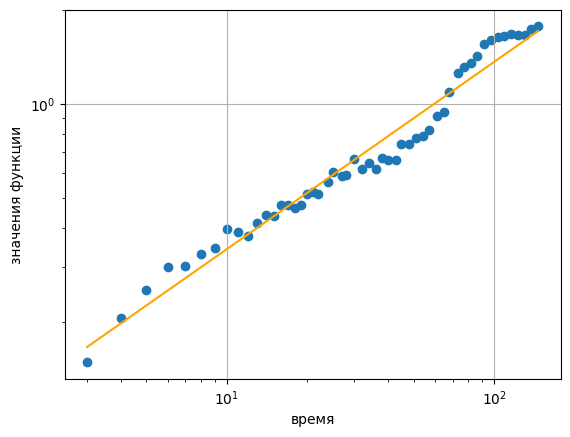

In [97]:
plt.loglog(10**(tlin), 10**(H_hat*tlin + C_hat), color = "orange")
plt.scatter(lag,dfa)
plt.xlabel("время")
plt.ylabel("значения функции")
plt.grid()
plt.show()

# **Пример обработки файла с историческими данными о курсе доллара к рублю**

In [ ]:
# загрузить последовательность из внешнего файла
# загрузить курс доллара
data_file = pd.read_csv("UsdRubTime.csv", sep = ';')

x_axis = 'Week'
y_axis = 'Close'

df_data = pd.DataFrame(data_file, columns = [x_axis, y_axis])

y = df_data[y_axis]
T = max(df_data[x_axis])
N = len(df_data[x_axis])
t = np.linspace(1, T, N)

In [ ]:
# обработка данных
print(df_data.head)

print(N, T)

In [ ]:
# загрузить последовательность из внешнего файла
# загрузить курс доллара
data_file = pd.read_csv("VVP Russia.csv", sep = ';')

x_axis = 'Year'
y_axis = 'GDPusd'

df_data = pd.DataFrame(data_file, columns = [x_axis, y_axis])

y = df_data[y_axis]
T = max(df_data[x_axis])
N = len(df_data[x_axis])
t = np.linspace(1, T, N)

In [ ]:
# удалить все данные из файла, которые больше чем заданный параметр
df_data = df_data[df_data.Week > 350]

print(df_data.head)

AttributeError: ignored

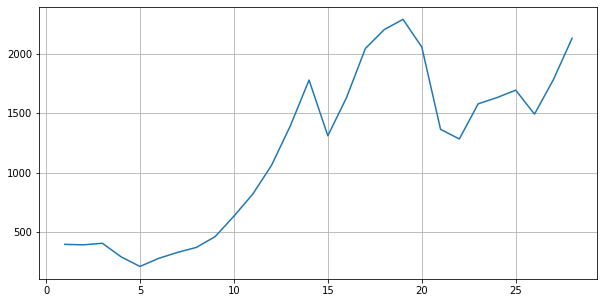

In [ ]:
# график временной зависимости
plt.figure(figsize = (10,5))
plt.grid()
plt.plot(t, y)
plt.show()

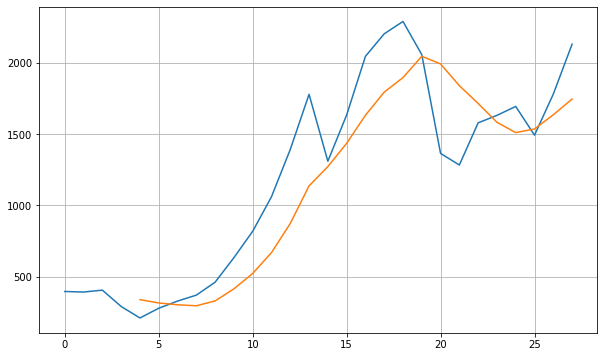

In [ ]:
# расчет скользящего среднего
y.plot(figsize=(10,6))
y.rolling(window = 5).mean().plot()
y_mean = y.rolling(window = 35).mean()
plt.grid()
plt.show()

In [ ]:
y_mean = y_mean[~np.isnan(y_mean)]
print(y_mean.head)

<bound method NDFrame.head of 4      338.438
5      314.944
6      302.254
7      295.248
8      329.350
9      413.948
10     521.884
11     668.228
12     872.584
13    1136.114
14    1271.396
15    1434.414
16    1631.338
17    1793.536
18    1895.706
19    2045.188
20    1991.360
21    1838.970
22    1714.118
23    1582.402
24    1509.750
25    1535.356
26    1634.824
27    1745.142
Name: GDPusd, dtype: float64>


<function matplotlib.pyplot.show(close=None, block=None)>

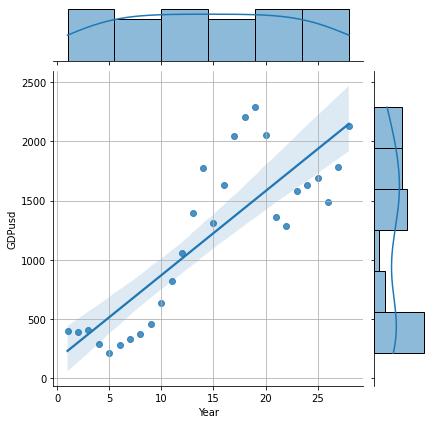

In [ ]:
seaborn.jointplot(data = df_data, x = x_axis, y = y_axis, kind='reg')
plt.grid()
plt.show

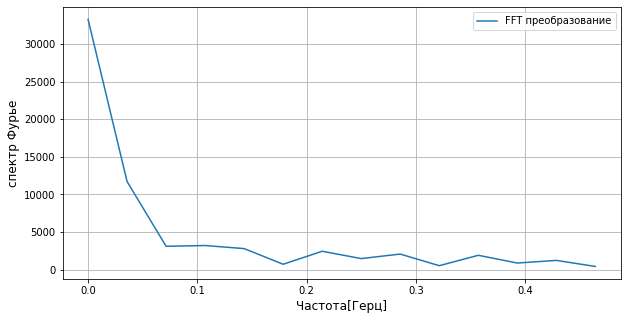

In [ ]:
from scipy.fft import fft, fftfreq

yf = fft(y.values)
xf = fftfreq(N, T/N)[:N//2]
# спект Фурье симметричен относительно нуля, поэтому берем только правую его часть
plt.figure(figsize=(10, 5))
plt.plot(xf, np.abs(yf[0:N//2]),label='FFT преобразование')
plt.xlabel('Частота[Герц]', fontsize=12)
plt.ylabel('спектр Фурье', fontsize=12)
plt.xticks(np.arange(0, np.max(xf), 0.1))
#plt.ylim(0,2000)
plt.grid()
plt.legend()
plt.show()

https://www.dmitrymakarov.ru/intro/time-series-20/#2-analiz-vremennykh-ryadov

In [ ]:
# автокорреляция
import statsmodels.api as sm

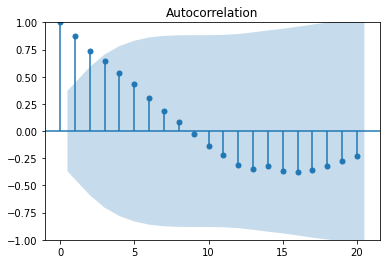

In [ ]:
sm.graphics.tsa.plot_acf(y, lags = 20, fft = True)
plt.show()

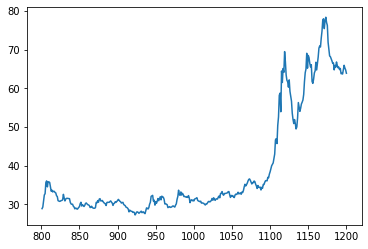

In [ ]:
plt.plot(t[800:1200], y[800:1200])


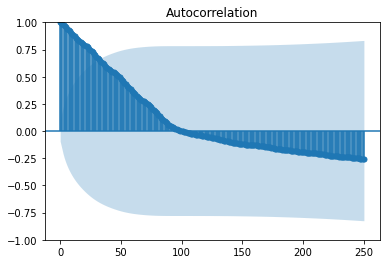

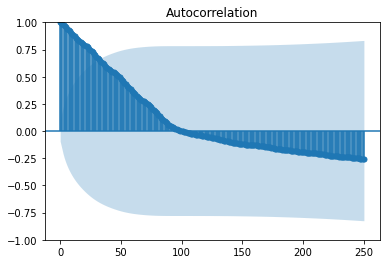

In [ ]:
sm.graphics.tsa.plot_acf(y[800:1200], lags = 250)


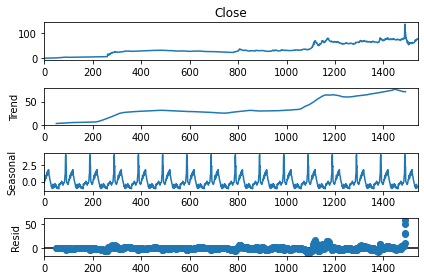

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(y, period = 100, model = "additive")
decompose.plot()


plt.show()

# Гипотеза Дикки-Фуллера